<a href="https://colab.research.google.com/github/fc510/sctp-caps-log-classifier/blob/main/sctp_ml_log_data_RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SCTP Assoc AI/ML Developer: Log Data Classification** testing

# Notebook Init

In [ ]:
import tensorflow as tf

def colab_gpu_check():
    # check
    !nvidia-smi
    print(f"tensorflow version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    print(gpus)
    print(cpus)

def colab_gpu_set(p_enable: bool=False):
    colab_gpu_check()
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    try:
        if p_enable:
            tf.debugging.set_log_device_placement(True)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                # tf.config.set_visible_devices(gpus[0], 'GPU')
                tf.config.set_visible_devices(gpu, 'GPU')
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        else:
            tf.config.set_visible_devices(cpus[0], 'CPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
colab_gpu_check()

/bin/bash: line 1: nvidia-smi: command not found
tensorflow version: 2.17.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
# colab_gpu_set(False)
colab_gpu_set(True)

/bin/bash: line 1: nvidia-smi: command not found
tensorflow version: 2.17.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
0 Physical GPUs, 0 Logical GPUs


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.set_visible_devices(gpus[0], 'GPU')
      tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
# mount google drive in colab
def mount_gg_drive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def git_clone(p_url: str=None):
    !git clone https://github.com/NMustikha/SCTP-Capstone-4-Fraud-Detection

mount_gg_drive()
# git_clone()

Mounted at /content/drive


In [ ]:
# install python packages
%pip install -r /content/drive/MyDrive/sctp-capstone-ml-log-data/requirements.txt

In [ ]:
## my
# import libraries
import pandas
pandas.options.display.max_columns = None
pandas.set_option('display.max_columns', None)

import pandas as pd
import numpy as np
from pprint import pprint as pp
import csv
import contractions
import string
import re
from unidecode import unidecode
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil
from chardet import detect
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Dataset

Dataset on log files are hosted at [Public Security Log Sharing Site](https://log-sharing.dreamhosters.com/), supported by [Dr. Anton A. Chuvakin](https://www.chuvakin.org/)

Bundle 1 log files is selected and accessible at [http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz](http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz)


The target log files for analysis are found in:
- `/var/log/httpd/access_log*`
- `/var/log/messages*`

These log files are:
- download the log file bundle
- untar the bundle
- respective log files are concatenated


In [ ]:
!curl -L http://log-sharing.dreamhosters.com/hnet-hon-var-log-02282006.tgz -o hnet-hon-var-log-02282006.tgz
!tar -C ./ -xvf hnet-hon-var-log-02282006.tgz

!ls ./var/log/httpd/ | grep access_log | xargs -I {} cat "./var/log/httpd/{}" >> ./access_log
!ls ./var/log/ | grep messages | xargs -I {} cat "./var/log/{}" >> ./messages

!cp ./access_log ./messages /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/

# cleanup
# !rm -rf ./hnet-hon-var-log-02282006.tgz ./var

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   274  100   274    0     0   7631      0 --:--:-- --:--:-- --:--:--  7828
100  100M  100  100M    0     0   104M      0 --:--:-- --:--:-- --:--:--  140M
var/log/
var/log/boot.log.30
var/log/tmplog
var/log/cron.2
var/log/cron.25
var/log/mysqld.log.23
var/log/mysqld.log.19
var/log/secure.20
var/log/maillog.8
var/log/maillog.15
var/log/messages.19
var/log/boot.log.9
var/log/boot.log.29
var/log/maillog.14
var/log/maillog.12
var/log/secure.16
var/log/snmpd.log.6
var/log/secure.13
var/log/rpmpkgs.25
var/log/spooler.6
var/log/messages.31
var/log/rpmpkgs.19
var/log/mysqld.log.15
var/log/cron.17
var/log/mysqld.log.2
var/log/rpmpkgs.21
var/log/cron.6
var/log/mysqld.log
var/log/secure.28
var/log/mysqld.log.29
var/log/maillog.5
var/log/messages.21
var/log/messages.23
var/log/messages.26
var/log/maillog.27
var/log/mail/
var/log/mail/stati

# Load, Clean and Convert to CSV File

Main steps:
1. Remove non-ascii characters from log files
2. Convert log file to csv structure


In [ ]:
# DATA_DIR = "../data" # local vs code setup
DATA_DIR = "/content" # google colab
HTTP_ACCESS_LOG_FILE = DATA_DIR+"/"+"access_log"
MESSAGES_FILE = DATA_DIR+"/"+"messages"

# filename for persisting the vectorizer and model
TFIDF_FILE = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav'
MODEL_FILE = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'

In [ ]:
from chardet import detect
def has_non_ascii(p_file: str = None):
    cnt = 0
    encoding = lambda x: detect(x)['encoding']
    # with open(tgt_file+".txt", 'a', encoding='utf-a') as fout:
    with open(tgt_file, 'rb') as f:
        for i in f.readlines():
            cnt += 1
            if encoding(i) != 'ascii':
                # print(f"line {cnt} ... contains non-ascii characters.")
                print(f"File {p_file} has non-ascii characters ... line [{cnt}] onwards.")

            # exit when first detected non-ascii line
            if cnt>0: return True
            else: return False


def scrub_non_ascii(p_file: str = None):
    cnt = 0
    encoding = lambda x: detect(x)['encoding']

    tgt_file = p_file
    cnt = 0
    line_nums = []
    # detect lines with non-ascii characters
    # https://www.w3schools.com/charsets/ref_html_8859.asp
    with open(tgt_file, 'rb') as fin:
        for i in fin.readlines():
            cnt += 1
            if encoding(i) != 'ascii':
                # print(f"line {cnt} ... contains {encoding(i)} characters ... ignored")
                line_nums.append(cnt)
            # else:
            #     print(f"line {cnt} ... contains {encoding(i)} characters")


    print(f"Lines with non-ascii characters:\n{line_nums}")
    cnt = 0
    with open(tgt_file, 'r', encoding='utf-8', errors='ignore') as fin:
        with open(tgt_file+".txt", 'w', encoding='utf-8') as fout:
            for i in fin.readlines():
                cnt += 1
                if cnt in line_nums:
                    print(f"line {cnt} ... skipped due to presence of non-ascii character.")
                else:
                    fout.write(i)
    print(f"New file written to [{tgt_file}.txt]")
    return f"{tgt_file}.txt"

def clean_str(p_str: str=None):

    str_lower = lambda x: str(x).lower() # lower casing
    str_exp_contraction = lambda x: " ".join([contractions.fix(expanded_word) for expanded_word in x.split()]) # expand contractions
    str_rm_punct = lambda x: re.sub('[%s]' % re.escape(string.punctuation.replace('/', '').replace('@','')), ' ' , x) # remove punctuations except '/' and '@'
    str_rm_spaces = lambda x: re.sub(' +', ' ', x) # remove double spaces
    str_rpl_diacritics = lambda x: unidecode(x, errors="preserve") # replace Diacritics with nearest characters.

    p_str = str_lower(p_str)
    p_str = str_exp_contraction(p_str)
    p_str = str_rm_punct(p_str)
    p_str = str_rm_spaces(p_str)
    p_str = str_rpl_diacritics(p_str)
    return p_str

def clean_logs(p_entry: pandas.Series=None):
    p_entry = pandas.Series(p_entry).apply(clean_str)
    # print(f"p_entry ... {type(p_entry)}")
    # print(f"{p_entry}")
    # return p_entry
    # result = []

    # for i in p_entry:
    #     clean_str(str(i))
    #     result.append(clean_str(str(i)))
    # return pandas.Series(result)


import pickle

# def save_model(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
def save_obj(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
    # save the model to disk
    filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
    # pickle.dump(best_model, open(filename, 'wb'))
    pickle.dump(p_obj, open(p_filename, 'wb'))

# def load_model(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
def load_obj(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
    # load the model from disk
    # filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
    return pickle.load(open(p_filename, 'rb'))


### convert httpd `access_log` to csv format

In [ ]:
tgt_file = HTTP_ACCESS_LOG_FILE

In [ ]:
import csv

def httpd_access_log_to_csv(p_file: str = None) -> list:
    logs = list()
    cnt = 0
    tgt_file = p_file
    if has_non_ascii(tgt_file):
        tgt_file = scrub_non_ascii(tgt_file)

    with open(tgt_file, 'r') as f:
        for i in f.readlines():
            cnt += 1
            # print(cnt)
            j = (i
                .replace('- [', '- @@')
                .replace('] "', '@@ "')
            )
            k = [ m.strip() for m in j.split('@@')]
            k[0] = k[0].replace(' - -', '')
            k[1] = k[1].replace(' -0500', '')
            k[1] = k[1].replace(' -0400', '')
            # k[2] = (k[2]
            #         .replace('"', '][')
            #         )        # print(k)
            k[2] = k[2][1:-1]
            k.append('httpd_access_log')
            logs.append(k)
    return logs


logs = httpd_access_log_to_csv(tgt_file)
fields = ['ipaddress','datetime','content','log_type']
# pp(logs[:3])
with open(tgt_file+'.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(logs)

pp(logs[:2])


Lines with non-ascii characters:
[]
New file written to [/content/access_log.txt]
[['66.186.236.233',
  '22/Jan/2006:07:35:42',
  'GET / HTTP/1.1" 403 3931 "-" "Mozilla/4.0 (compatible; MSIE 5.5; Windows '
  '98)',
  'httpd_access_log'],
 ['65.103.133.250',
  '22/Jan/2006:07:56:32',
  'GET / HTTP/1.1" 403 3931 "-" "Mozilla/4.0 (compatible; MSIE 5.5; Windows '
  '98)',
  'httpd_access_log']]


In [ ]:
tgt_file = HTTP_ACCESS_LOG_FILE+'.csv'

In [ ]:
df = pd.read_csv(tgt_file)
df.head()
# print(f"[{df[:2]['datetime'].str.lower()}]")
# df['date'] = df['datetime'].str[:11]
# df['time'] = df['datetime'].str[12:]
df['datetime'] = df['datetime'].str.replace(":"," ", 1)
df.head()

df['datetime'] = pd.to_datetime(df['datetime'],dayfirst=True)

df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
# df['day_of_week'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

df.info()

df['content'] = clean_log_entry(df['content'])
df.drop('ipaddress', inplace=True, axis=1)
display(df.head())

df = df[df['content'].notnull()]
display(df[df['content'].isnull()])

tgt_file = HTTP_ACCESS_LOG_FILE+'_final.csv'
df.to_csv(tgt_file,index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36424 entries, 0 to 36423
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ipaddress  36424 non-null  object        
 1   datetime   36424 non-null  datetime64[ns]
 2   content    36424 non-null  object        
 3   log_type   36424 non-null  object        
 4   day        36424 non-null  int32         
 5   month      36424 non-null  int32         
 6   year       36424 non-null  int32         
 7   hour       36424 non-null  int32         
 8   minute     36424 non-null  int32         
 9   second     36424 non-null  int32         
dtypes: datetime64[ns](1), int32(6), object(3)
memory usage: 1.9+ MB


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,get / http/11 403 3931 mozilla/40 compatible m...,httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,get / http/11 403 3931 mozilla/40 compatible m...,httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17


,datetime,content,log_type,day,month,year,hour,minute,second


### convert `messages` log file to csv

#### Error due to presence of non-ascii characters

In [ ]:
tgt_file = MESSAGES_FILE

In [ ]:
def sys_msg_to_csv(p_file: str = None) -> list:
    msg = list()
    cnt = 0
    tgt_file = p_file
    if has_non_ascii(tgt_file):
        tgt_file = scrub_non_ascii(tgt_file)

    with open(tgt_file, 'r', encoding='utf-8') as f:
        for i in f.readlines():
            cnt += 1
            # print(cnt)
            j = (i
                .replace(' combo ', '@@')
            )
            k = [ m.strip() for m in j.split('@@')]

            k[1] = k[1].replace(':', '@@', 1)
            tmp = k[1].split('@@')
            # print(f"{len(tmp)} {tmp}")
            k[1] = tmp[0].strip()
            if len(tmp)>1:
                k.append(tmp[1].strip())
            else:
                k.append([''])
            k.append('system_messages')
            msg.append(k)

    # ic(msg)
    return msg


msg = sys_msg_to_csv(tgt_file)

fields = ['datetime','component','content','log_type']
with open(tgt_file+'.csv', 'w') as f:
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(msg)

Lines with non-ascii characters:
[259, 260, 261, 262, 263, 2889, 2890, 2891, 3358, 3359, 6972, 10830, 10831, 12227, 12360, 12361, 12362, 12363, 12364, 12365]
line 259 ... skipped due to presence of non-ascii character.
line 260 ... skipped due to presence of non-ascii character.
line 261 ... skipped due to presence of non-ascii character.
line 262 ... skipped due to presence of non-ascii character.
line 263 ... skipped due to presence of non-ascii character.
line 2889 ... skipped due to presence of non-ascii character.
line 2890 ... skipped due to presence of non-ascii character.
line 2891 ... skipped due to presence of non-ascii character.
line 3358 ... skipped due to presence of non-ascii character.
line 3359 ... skipped due to presence of non-ascii character.
line 6972 ... skipped due to presence of non-ascii character.
line 10830 ... skipped due to presence of non-ascii character.
line 10831 ... skipped due to presence of non-ascii character.
line 12227 ... skipped due to presence 

### messages log

In [ ]:
tgt_file = MESSAGES_FILE+'.csv'

In [ ]:
import dateutil.utils

df = pd.read_csv(tgt_file)
display(df.head())

# df['datetime'] = [ i.split() for i in df['datetime'].str.replace(":"," ", 1) ]

df['datetime'] = [ i.split() for i in df['datetime'] ]
df['datetime'] = [ ' '.join([i[1],i[0],'2017',i[2]]) for i in df['datetime'] ]
# df['datetime'] = [ ' '.join([' '.join([i[2],i[0],'20'+i[1]]),':'.join([i[3],'00'])]) for i in df['datetime'] ]
# display(df.head())

df['datetime'] = pd.to_datetime(df['datetime'],dayfirst=True)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['content'] = df['component'] + ' ' + df['content']
df.drop('component', inplace=True, axis=1)
df = df[df['content'].notnull()]

df['content'] = clean_log_entry(df['content'])

display(df.head())
display(df.info())

df.to_csv(MESSAGES_FILE+'_final.csv',index=False)


,datetime,component,content,log_type
0,Jan 22 04:11:04,syslogd 1.4.1,restart.,system_messages
1,Jan 22 04:11:04,logrotate,ALERT exited abnormally with [1],system_messages
2,Jan 22 04:16:40,su(pam_unix)[21719],session opened for user news by (uid=0),system_messages
3,Jan 22 04:16:41,su(pam_unix)[21719],session closed for user news,system_messages
4,Jan 22 05:23:19,sshd(pam_unix)[24892],check pass; user unknown,system_messages


,datetime,content,log_type,year,month,day,hour,minute,second
0,2017-01-22 04:11:04,syslogd 141 restart,system_messages,2017,1,22,4,11,4
1,2017-01-22 04:11:04,logrotate alert exited abnormally with 1,system_messages,2017,1,22,4,11,4
2,2017-01-22 04:16:40,supamunix21719 session opened for user news by...,system_messages,2017,1,22,4,16,40
3,2017-01-22 04:16:41,supamunix21719 session closed for user news,system_messages,2017,1,22,4,16,41
4,2017-01-22 05:23:19,sshdpamunix24892 check pass user unknown,system_messages,2017,1,22,5,23,19


<class 'pandas.core.frame.DataFrame'>
Index: 25454 entries, 0 to 25546
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  25454 non-null  datetime64[ns]
 1   content   25454 non-null  object        
 2   log_type  25454 non-null  object        
 3   year      25454 non-null  int32         
 4   month     25454 non-null  int32         
 5   day       25454 non-null  int32         
 6   hour      25454 non-null  int32         
 7   minute    25454 non-null  int32         
 8   second    25454 non-null  int32         
dtypes: datetime64[ns](1), int32(6), object(2)
memory usage: 1.4+ MB


None

***
# Exploratory Data Analysis

In [ ]:
# DATA_DIR = "../data"
DATA_DIR = "/content"
HTTP_ACCESS_LOG_CSV = DATA_DIR+"/"+"access_log_final.csv"
MESSAGES_CSV = DATA_DIR+"/"+"messages_final.csv"

## Consolidate into 1 Dataset

In [ ]:
# further consolidate the column data

tgt_file = HTTP_ACCESS_LOG_CSV
df_httpd = pd.read_csv(tgt_file)
# df_httpd.drop('ipaddress', axis=1, inplace=True)
# display(df_httpd.head())
# display(df_httpd.info())

tgt_file = MESSAGES_CSV
df_msg = pd.read_csv(tgt_file)
# df_msg['content'] = df_msg['component'] + ' ' + df_msg['content']
# df_msg.drop('component', axis=1, inplace=True)
# df_msg.info()

display(df_msg[df_msg['content'].isnull()])
df_msg = df_msg[df_msg['content'].notnull()]
display(df_msg[df_msg['content'].isnull()])

df = pandas.concat([df_httpd,df_msg],ignore_index=True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.to_csv(DATA_DIR+'/'+'combined_log.csv',index=False)
!cp {DATA_DIR+'/'+'combined_log.csv'} /content/drive/MyDrive/sctp-capstone-ml-log-data/dataset/dataset.csv

print("Check for rows with nulls")
display(df[df['content'].notnull()])

display(df[df['log_type']=='httpd_access_log'].head())
display(df[df['log_type']=='system_messages'].head())
df.info()

,datetime,content,log_type,year,month,day,hour,minute,second


,datetime,content,log_type,year,month,day,hour,minute,second


Check for rows with nulls


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,get / http/11 403 3931 mozilla/40 compatible m...,httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,get / http/11 403 3931 mozilla/40 compatible m...,httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
...,...,...,...,...,...,...,...,...,...
61873,2017-11-26 23:16:43,kernel out of memory killed process 20873 python,system_messages,26,11,2017,23,16,43
61874,2017-11-27 04:05:58,supamunix21736 session opened for user cyrus b...,system_messages,27,11,2017,4,5,58
61875,2017-11-27 04:05:59,supamunix21736 session closed for user cyrus,system_messages,27,11,2017,4,5,59
61876,2017-11-27 04:06:06,cups cupsd shutdown succeeded,system_messages,27,11,2017,4,6,6


,datetime,content,log_type,day,month,year,hour,minute,second
0,2006-01-22 07:35:42,get / http/11 403 3931 mozilla/40 compatible m...,httpd_access_log,22,1,2006,7,35,42
1,2006-01-22 07:56:32,get / http/11 403 3931 mozilla/40 compatible m...,httpd_access_log,22,1,2006,7,56,32
2,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
3,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17
4,2006-01-22 08:28:17,get /awstats/awstatsplconfigdirechoecho20yyycd...,httpd_access_log,22,1,2006,8,28,17


,datetime,content,log_type,day,month,year,hour,minute,second
36424,2017-01-22 04:11:04,syslogd 141 restart,system_messages,22,1,2017,4,11,4
36425,2017-01-22 04:11:04,logrotate alert exited abnormally with 1,system_messages,22,1,2017,4,11,4
36426,2017-01-22 04:16:40,supamunix21719 session opened for user news by...,system_messages,22,1,2017,4,16,40
36427,2017-01-22 04:16:41,supamunix21719 session closed for user news,system_messages,22,1,2017,4,16,41
36428,2017-01-22 05:23:19,sshdpamunix24892 check pass user unknown,system_messages,22,1,2017,5,23,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61878 entries, 0 to 61877
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  61878 non-null  datetime64[ns]
 1   content   61878 non-null  object        
 2   log_type  61878 non-null  object        
 3   day       61878 non-null  int64         
 4   month     61878 non-null  int64         
 5   year      61878 non-null  int64         
 6   hour      61878 non-null  int64         
 7   minute    61878 non-null  int64         
 8   second    61878 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 4.2+ MB


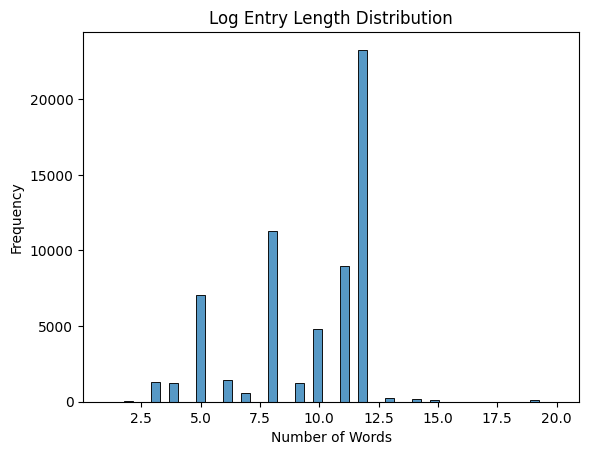

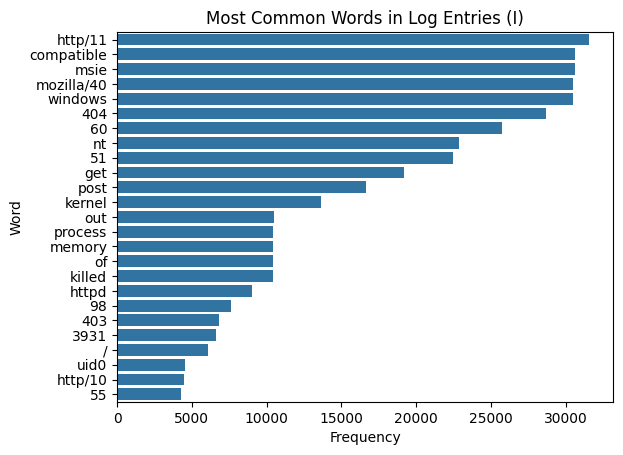

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of log entries' lengths
# df_content = df['content']

def eda_word_count(p_df: pandas.Series=None) -> None:
    # print(p_df.apply(lambda x: len(str(x).split())))
    df_content = p_df
    df['log_length'] = df_content.apply(lambda x: len(str(x).split()))
    sns.histplot(df['log_length'], bins=50)
    plt.title('Log Entry Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

def eda_word_freq(p_df: pandas.Series=None)->None:
    df_content = p_df
    # Extracting and visualizing most common log entries (terms)
    from collections import Counter
    all_words = ' '.join(df_content).split()
    # print(f"all_words >>> {all_words}")
    common_words = Counter(all_words).most_common(50)

    # Bar plot for most common words
    common_words_df = pd.DataFrame(common_words[:25], columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title('Most Common Words in Log Entries (I)')
    plt.show()

    return
    common_words_df = pd.DataFrame(common_words[26:], columns=['Word', 'Frequency'])
    sns.barplot(x='Frequency', y='Word', data=common_words_df)
    plt.title('Most Common Words in Log Entries (II)')
    plt.show()

eda_word_count(df['content'].copy())
# display(df.loc[14740:14750])
eda_word_freq(df['content'].copy())

# Feature Extraction

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
# feature extraction

# def feature_extraction(p_df: pandas.DataFrame=None, p_col_content: str='content', p_col_label: str='log_type'):
p_df = df
p_col_content = 'content'
p_col_label = 'log_type'

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(p_df[p_col_content]).toarray()

# column label for log data
y = LabelEncoder().fit_transform(df[p_col_label])

In [ ]:
save_obj(p_obj=tfidf, p_filename=TFIDF_FILE)

# Model Training, Testing & Validation

**Key hyperparameters** that can be further tuned or included to improve model performance:
- `clf__n_estimators` (number of trees in the forest)
- `clf__max_depth` (maximum depth of the individual trees; limits the number of nodes in the tree)
- `clf__min_samples_leaf` (minimum samples required to be at a leaf node)
- `max_features` (number of features to consider at each split)



In a Random Forest, each decision tree is trained on a random subset of the features. The `max_features` parameter controls how many features are considered when splitting a node in each tree. This randomness helps to ensure that the trees are not too similar to each other, which is a key aspect of the ensemble method.

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Pipeline with RandomForestClassifier
pipeline = Pipeline([
    ('clf', RandomForestClassifier())
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=4)
grid_search.fit(X_train, y_train)

# Best parameters and model
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


# Save Model

In [ ]:
import pickle

# def save_model(p_obj=None, p_filename: str='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
#     # save the model to disk
#     filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
#     # pickle.dump(best_model, open(filename, 'wb'))
#     pickle.dump(p_obj, open(p_filename, 'wb'))

# def load_model(p_filename: str = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'):
#     # load the model from disk
#     # filename = '/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
#     return pickle.load(open(p_filename, 'rb'))


In [ ]:
save_obj(p_obj=best_model, p_filename=MODEL_FILE)

# Load & Evaluate Model

In [ ]:
tgt_tfidf = load_obj(p_filename=TFIDF_FILE)
tgt_model = load_obj(p_filename=MODEL_FILE)

NameError: name 'load_obj' is not defined

In [ ]:
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Accuracy: 0.4169360051712993
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7216
           1       0.42      1.00      0.59      5160

    accuracy                           0.42     12376
   macro avg       0.21      0.50      0.29     12376
weighted avg       0.17      0.42      0.25     12376



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


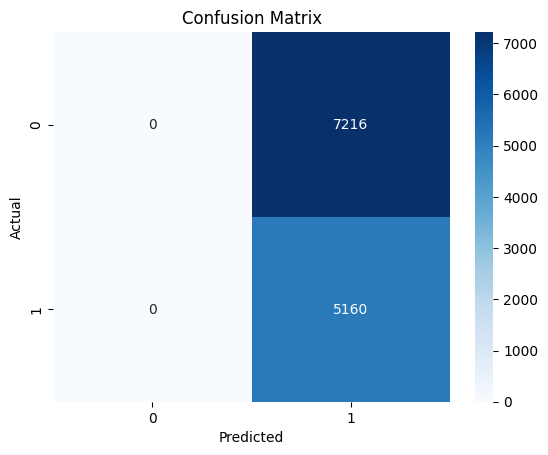

In [ ]:
# Predicting on test set
y_pred = tgt_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Deploy Model for Inference

In [ ]:
# tgt_model = load_obj(p_filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav')
# save_obj(p_obj=tfidf, p_filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav')

model = None
tfidf_vectorizer = None

# Load the trained model from the pickle file
# filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'log_classifier_model.sav'
filename = MODEL_FILE
with open(filename, 'rb') as model_file:
    model = pickle.load(model_file)

# Load the TF-IDF vectorizer
# filename='/content/drive/MyDrive/sctp-capstone-ml-log-data/model/'+'tfidf_vectorizer.sav'
filename = TFIDF_FILE
with open(filename, 'rb') as vectorizer_file:
    tfidf_vectorizer = pickle.load(vectorizer_file)

print(tfidf_vectorizer)
print(model)

TfidfVectorizer(max_features=5000)
Pipeline(steps=[('clf', RandomForestClassifier())])


In [ ]:

# def classify_log(input_text: list = None):
#     # Preprocess and vectorize the input text

#     # [ print(f"{type(i)} {len(i)} {i}") for i in input_text ]

#     # input_text_cleaned = clean_str(input_text)
#     input_text_cleaned = [ clean_str(i) for i in input_text if len(i)>0 ]
#     [ print(f"{type(i)} {len(i)} {i}") for i in input_text_cleaned ]

#     # input_vector = tfidf_vectorizer.transform([input_text_cleaned]).toarray()
#     input_vector = tfidf_vectorizer.transform(input_text_cleaned).toarray()

#     # Predict the log type
#     prediction = model.predict(input_vector)

#     # Return the prediction as a readable label
#     return f"Predicted Log Type: {prediction[0]}"

# s2 = '"POST /xmlrpc/xmlrpc.php HTTP/1.1" 404 295 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1;)"'
# s1 = """
# "POST /xmlrpc/xmlrpc.php HTTP/1.1" 404 295 "-" "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1;)"
# "abc 123"
# """
# # print(s1.split('\n'))
# print(classify_log(s1.split('\n')))



<class 'str'> 89  post /xmlrpc/xmlrpc php http/1 1 404 295 mozilla/4 0 compatible msie 6 0 windows nt 5 1 
<class 'str'> 9  abc 123 
Predicted Log Type: 1


In [ ]:

def classify_log(input_text: list = None):
    tmp = input_text.split('\n')
    print(f"{type(input_text)}\n{tmp}")

    # Preprocess and vectorize the input text
    # input_text_cleaned = clean_str(input_text)
    input_text_cleaned = [ clean_str(i) for i in input_text.split('\n') if len(i)>0 ]
    print(input_text_cleaned)

    # input_vector = tfidf_vectorizer.transform([input_text_cleaned]).toarray()
    input_vector = tfidf_vectorizer.transform(input_text_cleaned).toarray()

    # Predict the log type
    prediction = model.predict(input_vector)

    # Return the prediction as a readable label
    return f"Predicted Log Type: {prediction[0]}"

# def classify_log_file(log_file):
#     # Read the text file and concatenate the lines into a single string
#     log_text = log_file.read().decode('utf-8')
#     return classify_log(log_text)

# Define the Gradio interface
iface = gr.Interface(
    fn=classify_log,  # Function to classify text input
    # inputs = gr.interface .inputs.Textbox(lines=10, placeholder="Enter log text here..."),  # Text input
    inputs = gr.Textbox(lines=3, placeholder="Enter log text (line by line) here..."),  # Text input
    outputs="text",  # Text output
    title="Log File Classifier",
    description="Submit 1 log entry per line to classify the type of log."
)

# iface_file_upload = gr.Interface(
#     fn=classify_log_file,  # Function to classify uploaded text file
#     # inputs=gr.inputs.File(type="file"),  # File input
#     inputs = gr.File(type="filepath"),  # File input
#     outputs="text",  # Text output
#     title="Log File Classifier (File Upload)",
#     description="Upload a log file to classify the type of log."
# )

# Combine both interfaces
# iface = gr.TabbedInterface([iface, iface_file_upload], ["Text Input", "File Upload"])
iface = gr.TabbedInterface([iface], ["Text Input"])

# Launch the interface
iface.launch(debug=True,share=True)



Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://06f43c35c8fe62c9a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


<class 'str'>
['sshd(pam_unix)[24935]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=server3.sugolan.hu ', 'sshd(pam_unix)[25820]: authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=61.129.113.52  user=root', 'nfslock: rpc.statd shutdown succeeded', '']
['sshd pam unix 24935 authentication failure logname uid 0 euid 0 tty nodevssh ruser rhost server3 sugolan hu', 'sshd pam unix 25820 authentication failure logname uid 0 euid 0 tty nodevssh ruser rhost 61 129 113 52 user root', 'nfslock rpc statd shutdown succeeded']
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://06f43c35c8fe62c9a9.gradio.live
